## Setup secrets

In [1]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
WANDB_TOKEN = user_secrets.get_secret("WANDB_TOKEN")

## Load Dataset

In [2]:
# Downgrade fsspec and rich to match other packages' requirements
%pip install --quiet fsspec==2024.10.0 rich<14
print("✅ fsspec and rich downgraded.")

%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets
print("✅ Initial libraries installed.")

# Install compatible CUDA libraries for torch 2.5.1+cu124
%pip install --quiet torch==2.5.1+cu124 torchvision==0.16.1+cu124 torchaudio==2.5.1+cu124 --extra-index-url https://download.pytorch.org/whl/cu124
print("✅ CUDA libraries installed.")


from datasets import load_dataset
# import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")
print("✅ Dataset loaded.")

/bin/bash: line 1: 14: No such file or directory
Note: you may need to restart the kernel to use updated packages.
✅ fsspec and rich downgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.2 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nv

README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

✅ Dataset loaded.


#### View Dataset

In [3]:
# Display the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})


#### Sample Data

In [4]:
import pandas as pd
df = pd.DataFrame(dataset['train'])
df.head(10)

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,1,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,2,positive
7,50e14c0bb8,Soooo high,1,neutral
8,e050245fbd,Both of you,1,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,2,positive


## HuggingFace Setup

In [5]:
import huggingface_hub

try:
    # login(token=HF_TOKEN)
    huggingface_hub.login(token=HF_TOKEN)
    print("✅ Logged in to Hugging Face Hub")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("✅ Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

✅ Logged in to Hugging Face Hub


## Load Model & Tokenizer

AutoTokenizer is a special class in the Huggingface Transformers library. It helps you choose the right tokenizer for your model without knowing the details.

Think of it as a smart assistant that knows which tool to use for the job.

The AutoTokenizer is easy to use. You don’t have to remember which tokenizer goes with which model. It ensures you use the correct tokenizer for the model, reducing errors and improving consistency.

Autotokenizer is flexible. It works with many different models, allowing you to switch models without changing much code.

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

HF_MODEL_NAME = "Qwen/Qwen2.5-0.5B"
MODEL_NAME_FOR_OUTPUT = HF_MODEL_NAME.split("/")[-1]    # Used for generating output directory

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
print("✅ Loaded Tokenizer")
base_model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME, num_labels=3)    
print("✅ Loaded Model")


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

✅ Loaded Tokenizer


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

2025-04-18 09:46:13.540528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744969573.830190      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744969573.904430      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded Model


#### Model Info

In [7]:
import json

def get_model_info(model):
    """Extract detailed information about the model."""
    model_info = {
        "Model Name": HF_MODEL_NAME,
        "Architecture": type(model).__name__,
        "Base Architecture": model.config.architectures[0] if hasattr(model.config, "architectures") else "N/A",
        "Model Type": model.config.model_type if hasattr(model.config, "model_type") else "N/A",
        "Number of Layers": len(list(model.model.layers)) if hasattr(model.model, "layers") else "N/A",
        "Total Parameters": sum(p.numel() for p in model.parameters()),
        "Trainable Parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "Non-Trainable Parameters": sum(p.numel() for p in model.parameters() if not p.requires_grad),  
        # some params like BatchNorm are not trainable; they are updated during training but not optimized using backpropagation. They are updated using mean and std calculations.
        "Device": next(model.parameters()).device.type,  # Get the device (as a string - done with .type) of the first parameter (GPU or CPU)
    }

    # List all layers and their parameters
    layers_info = []
    for name, module in model.named_modules():  # Get all modules (i.e. layers in pytorch terminology) in the network: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
        layers_info.append({
            "Layer Name": name,
            "Layer Type": type(module).__name__,
            # module.parameters() returns an iterator over module parameters, which are the weights and biases of the layer (i.e. tensor). https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
            # p.numel() returns the total number of elements in the tensor (i.e. the number of parameters in the layer). https://pytorch.org/docs/stable/generated/torch.numel.html#torch.numel
            "Number of Parameters": sum(p.numel() for p in module.parameters()),
            "Trainable Parameters": sum(p.numel() for p in module.parameters() if p.requires_grad),
        })

    model_info["Layers"] = layers_info

    return model_info

# Get model information
model_info = get_model_info(base_model)

# Print model summary
print(f"Model Name: {model_info['Model Name']}")
print(f"Architecture: {model_info['Architecture']}")
print(f"Base Architecture: {model_info['Base Architecture']}")
print(f"Model Type: {model_info['Model Type']}")
print(f"Number of Layers: {model_info['Number of Layers']}")
print(f"Total Parameters: {model_info['Total Parameters']:,}")
print(f"Trainable Parameters: {model_info['Trainable Parameters']:,}")
print(f"Non-Trainable Parameters: {model_info['Non-Trainable Parameters']:,}")
print(f"Device: {model_info['Device']}")
print("\nLayers:")
for layer in model_info["Layers"]:
    print(f"  - {layer['Layer Name']} ({layer['Layer Type']}): {layer['Number of Parameters']:,} params")

# # Optional: Save the model info to a file
MODEL_INFO_FILE = "model_info.json"
with open(MODEL_INFO_FILE, "w") as f:
    json.dump(model_info, f, indent=4)
    print(f"✅ Model information saved to {MODEL_INFO_FILE}")

Model Name: Qwen/Qwen2.5-0.5B
Architecture: Qwen2ForSequenceClassification
Base Architecture: Qwen2ForCausalLM
Model Type: qwen2
Number of Layers: 24
Total Parameters: 494,035,456
Trainable Parameters: 494,035,456
Non-Trainable Parameters: 0
Device: cpu

Layers:
  -  (Qwen2ForSequenceClassification): 494,035,456 params
  - model (Qwen2Model): 494,032,768 params
  - model.embed_tokens (Embedding): 136,134,656 params
  - model.layers (ModuleList): 357,897,216 params
  - model.layers.0 (Qwen2DecoderLayer): 14,912,384 params
  - model.layers.0.self_attn (Qwen2Attention): 1,836,160 params
  - model.layers.0.self_attn.q_proj (Linear): 803,712 params
  - model.layers.0.self_attn.k_proj (Linear): 114,816 params
  - model.layers.0.self_attn.v_proj (Linear): 114,816 params
  - model.layers.0.self_attn.o_proj (Linear): 802,816 params
  - model.layers.0.mlp (Qwen2MLP): 13,074,432 params
  - model.layers.0.mlp.gate_proj (Linear): 4,358,144 params
  - model.layers.0.mlp.up_proj (Linear): 4,358,144 p

#### View all special tokens

In [8]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

#### Tokenize Text (Split + Encode)

In [9]:
# Setting the pad token. By default, LLaMA models do not have a pad token, so we need to set it manually.
print(tokenizer.pad_token)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("✅ Pad token set to EOS token.")

base_model.resize_token_embeddings(len(tokenizer))  # Resize the model's token embeddings to match the tokenizer's vocabulary size
base_model.config.pad_token_id = tokenizer.pad_token_id # Set the pad token ID in the model's config
print(f"✅ Model pad_token_id set.")

def tokenize_function(examples):
    # padding set make the batches equal to the value set in max_length 
    # truncation set to True to truncate the text if it exceeds max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(f"Tokenized dataset:\n{tokenized_datasets}")

train_and_validation_dataset = tokenized_datasets["train"]
split = train_and_validation_dataset.train_test_split(test_size=0.1)
train_dataset = split["train"]
validation_dataset = split["test"]

# Clean up to free memory
del train_and_validation_dataset
del tokenized_datasets

print(f"✅ Dataset split done:\ntrain size: {len(train_dataset)}\nvalidation size: {len(validation_dataset)}\ntest size: {len(test_dataset)}")

<|endoftext|>
✅ Model pad_token_id set.


Map:   0%|          | 0/27481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 3534
    })
})
✅ Dataset split done:
train size: 27481
validation size: 1767
test size: 1767


### Sample Tokenized Data

In [10]:
train_dataset[0]  # Check the first example in the training dataset

{'id': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'label': 1,
 'label_text': 'neutral',
 'input_ids': [358,
  63,
  67,
  614,
  16441,
  11,
  421,
  358,
  1033,
  2087,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  151643,
  15164

## Fine Tune

### Evaluation metrics

In [11]:
%pip install --quiet evaluate
import evaluate
import numpy as np

f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")
# precision = evaluate.load("precision") # There is an error in huggingface module
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   return {
         "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
         "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
         # "precision": precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
         "recall": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"],
   }
   # Refer: https://huggingface.co/evaluate-metric

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Training Progress Callback

In [12]:
from transformers import TrainerCallback

class ProgressVisualizationCallback(TrainerCallback):
    def __init__(self):
        self.training_logs = []
        self.output_id = 'progress_viz'
        self.fig = None
    
    def on_train_begin(self, args, state, control, **kwargs):
        self.training_logs = []
        # Don't print anything here to avoid interfering with the default progress display
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            self.training_logs.append(logs)
            # Plot every 10 logs to avoid slowing down training
            if len(self.training_logs) % 10 == 0:
                self.visualize_progress(state)
    
    def visualize_progress(self, state):
        # Extract metrics
        steps = [log.get('step', i) for i, log in enumerate(self.training_logs) if 'loss' in log]
        loss = [log['loss'] for log in self.training_logs if 'loss' in log]
        lr = [log['learning_rate'] for log in self.training_logs if 'learning_rate' in log]
        
        # Create plot
        if self.fig is None:
            self.fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            display(self.fig, display_id=self.output_id)
        else:
            # Clear previous plot data
            for ax in self.fig.axes:
                ax.clear()
            ax1, ax2 = self.fig.axes
        
        # Loss plot
        ax1.plot(steps, loss, label='Training Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Learning rate plot
        ax2.plot(steps, lr, label='Learning Rate', color='green')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.legend()
        ax2.grid(True)
        
        self.fig.tight_layout()
        update_display(self.fig, display_id=self.output_id)
        
        # Don't print status here to avoid interfering with the default progress display


### WandB Setup

In [13]:
%pip install --quiet wandb
import wandb

try:
    wandb.login(key=WANDB_TOKEN)
    print("✅ Logged in to Weights & Biases")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("⚠ Please ensure you have a valid Weights & Biases token in your .env file.")
    exit(1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rtweera (rtw-rtweera) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Logged in to Weights & Biases


### Setup Training Arguments

In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo   # only available in python 3.9+

TIMEZONE = ZoneInfo("Asia/Colombo")
timestamp = datetime.now(tz=TIMEZONE).strftime("%Y-%m-%d_%H-%M-%S") # correct time regardless of server location
OUTPUT_DIR = f"{MODEL_NAME_FOR_OUTPUT}_{timestamp}"

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, # Directory to save model checkpoints & predictions ALSO Hugging Face Hub repo name is this
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=1,  # Log every x steps (mydef is 50)
    eval_strategy="steps",    
    eval_steps=1,   # mydef 100 # Evaluate every {eval_steps * gradient_accumulation_steps} steps
    save_strategy="steps",
    save_steps=1,    # Save model every {save_steps * grad_acc_steps} steps (mydef 100)
    # save_only_model=True,  # Only save model weights, not optimizer state
    save_total_limit=2,  # Keep only the last x checkpoints
    per_device_train_batch_size=4,  # max is 4 for 2xT4 GPU (16GB)
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=32,  # Accumulate gradients over x steps, allows for larger effective batch size 
    eval_accumulation_steps=8,  # Same for evaluation
    fp16=True, # Enable mixed precision training (if supported by the GPU) when needed
    num_train_epochs=0.3,
    # max_steps=200,    # Set a specific number of steps
    learning_rate=2e-5,
    weight_decay=0.01,  # L2 regularization
    load_best_model_at_end=True,  # Load the best model at the end of training to MEMORY, not push it to hub
    metric_for_best_model="eval_f1", # Use this returned from the compute_metrics function. (eval prefix is added by Trainer)
    greater_is_better=True,  # should metric for best be greater or smaller?
    report_to="wandb",  # Report to wandb (or tensorboard) for logging
    run_name=OUTPUT_DIR,  # Name of the run in wandb
    push_to_hub=True,  # Push the model to Hugging Face Hub after training
    hub_strategy="checkpoint",  # Push the model to the hub at checkpoints
    lr_scheduler_type="reduce_lr_on_plateau",  # Learning rate schedule type (linear, cosine, etc.)
)

# Save tokenizer to match training output_dir
tokenizer.save_pretrained(training_args.output_dir)

('Qwen2.5-0.5B_2025-04-18_15-17-00/tokenizer_config.json',
 'Qwen2.5-0.5B_2025-04-18_15-17-00/special_tokens_map.json',
 'Qwen2.5-0.5B_2025-04-18_15-17-00/vocab.json',
 'Qwen2.5-0.5B_2025-04-18_15-17-00/merges.txt',
 'Qwen2.5-0.5B_2025-04-18_15-17-00/added_tokens.json',
 'Qwen2.5-0.5B_2025-04-18_15-17-00/tokenizer.json')

### Setup Trainer

In [15]:
from transformers import Trainer

# Create the trainer with the callback
progress_callback = ProgressVisualizationCallback()
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    callbacks=[progress_callback],  # Add the callback here
)

### Fine Tune

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Recall
1,5.732400,26.539021,0.356537,0.241589,0.356537
2,25.548600,13.161389,0.354273,0.293876,0.354273
3,14.243200,18.034567,0.302207,0.141720,0.302207
4,18.662600,10.558477,0.278438,0.122030,0.278438
5,10.506900,16.986280,0.421053,0.249513,0.421053
6,17.374500,28.025770,0.301641,0.140532,0.301641
7,28.958800,21.105307,0.278438,0.122030,0.278438
8,20.144200,4.795628,0.421053,0.249513,0.421053
9,4.999100,5.674350,0.301641,0.140532,0.301641
10,5.977400,2.250337,0.279004,0.123265,0.279004


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


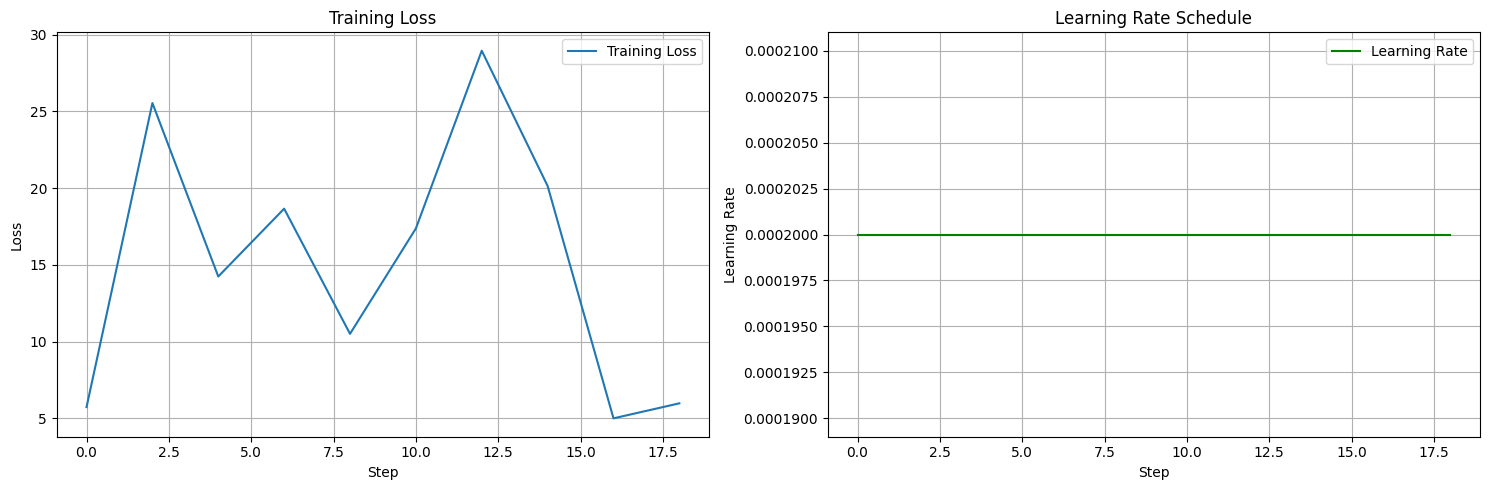

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

KeyboardInterrupt: 

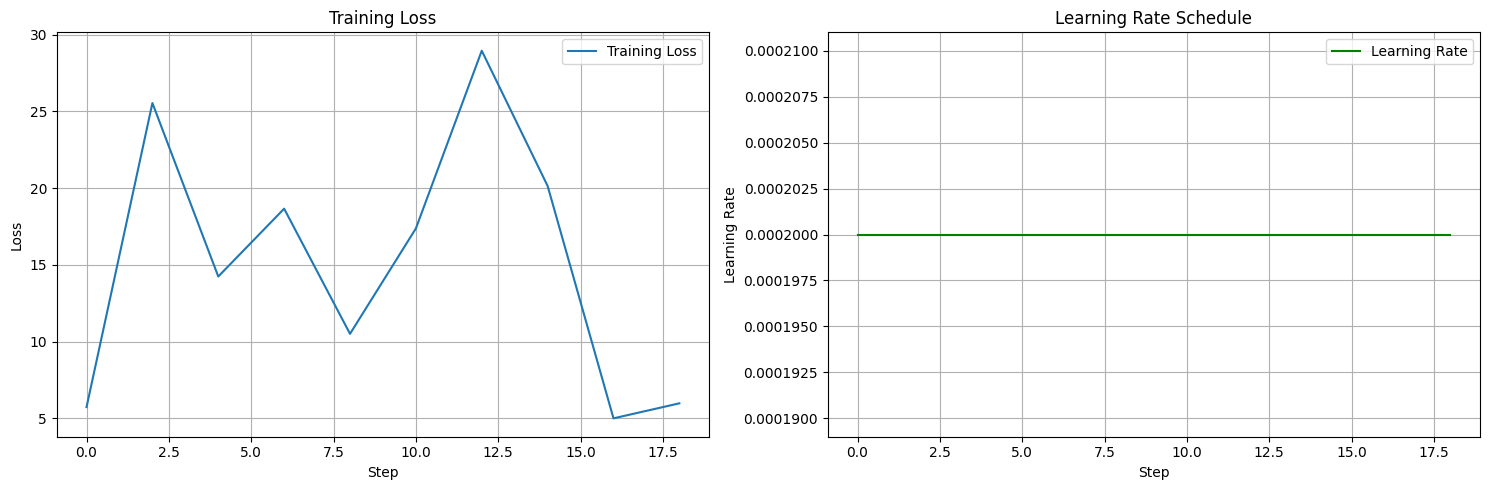

In [16]:
import matplotlib.pyplot as plt
from IPython.display import display, update_display, HTML

# Start training
print("Starting training...")
trainer.train()
print("Training completed.")

### Evaluate the best model

This is done because the evaluation metrics for the last run are saved as the automatically generated model card.
So we evaluate the best model, and then we save the model card with the evaluation metrics for the best model. (This is done in the `evaluate` method of the Trainer class.)

In [ ]:
eval_metrics = trainer.evaluate()
trainer.log_metrics("eval", eval_metrics)   # Log metrics to wandb
trainer.save_metrics("eval", eval_metrics)      
print(f"✅ Eval done")

### Push the model to Hub

You can't directly upload a folder using trainer.push_to_hub(). So doing it manually.

In [ ]:
# Save locally
BEST_MODEL_DIR = "best_model"
trainer.model.save_pretrained(BEST_MODEL_DIR)
tokenizer.save_pretrained(BEST_MODEL_DIR)
print(f"✅ Model saved locally to {BEST_MODEL_DIR} directory.")

from huggingface_hub import upload_folder
HF_UNAME = "rtweera"
REPO_ID = f"{HF_UNAME}/{OUTPUT_DIR}"
upload_folder(
    repo_id=REPO_ID,
    folder_path=BEST_MODEL_DIR,
    path_in_repo=BEST_MODEL_DIR,  # creates a folder inside repo
    commit_message="Upload best model after final validation"
)
print(f"✅ Model uploaded to Hugging Face Hub at {REPO_ID}/{BEST_MODEL_DIR}")